In [5]:
import numpy as np
class NaiveBayesClassifier:
    def __init__(self):
        #store P(c): for example,{"yes":10,"no":7}
        self.class_prior_probs = {}
        #stor P(xi|c): for example,{"yes":{"Color":{"A":p(’A’|’yes’)}}}
        self.class_condt_probs = {}
    #estimate class prior probs P(c)
    def estimate_class_prior_probs(self, y_train):
        inst_num = len(y_train)
        #count sample number of each class
        for i in range(inst_num):
            key = y_train[i]
            if key not in self.class_prior_probs.keys():
                self.class_prior_probs[key]=0
            self.class_prior_probs[key] += 1
        #calculate class frequency
        for key in self.class_prior_probs:
            self.class_prior_probs[key] =\
                float(self.class_prior_probs[key])/inst_num
    #estimate class condition probs, P(x_i|c)
    def estimate_class_condt_probs(self, x_train,y_train,feature_names,feature_types,labels):
        # get feature number and instance number
        feature_num = len(feature_names)
        inst_num = len(x_train)
        self.inst_num = inst_num
        #estimate P(x_i|c)
        for label in labels:
            self.class_condt_probs[label]={}
            self.class_condt_probs[label]["num"]=0
            for feature in feature_names:
                self.class_condt_probs[label][feature]={}
            for i in range(inst_num):
                if y_train[i]==label:
                    self.class_condt_probs[label]["num"] += 1
            for i in range(feature_num):
                if feature_types[i]==1:#for discrete feature
                    for j in range(inst_num):
                        if y_train[j]==label:
                            if x_train[j,i] not in self.class_condt_probs[label][
                                feature_names[i]].keys():
                                self.class_condt_probs[label][feature_names[i]][x_train[j,i]]=0
                            self.class_condt_probs[label][feature_names[i]][x_train[j,i]] += 1
                else:#for continuous feature
                    values = []
                    for j in range(inst_num):
                        if y_train[j]==label:
                            values.append(float(x_train[j,i]))
                    values = np.array(values)
                    mean_values = np.mean(values)
                    var_values = np.var(values)
                    self.class_condt_probs[label][feature_names[i]]["mean"]=mean_values
                    self.class_condt_probs[label][feature_names[i]]["var"]=var_values
    # calculate P(xi|c) for continous feature
    def normal_prob_dense(self,x,mu,std):
        import math
        #see Eq.(6.11)
        p = 1.0/(std*pow(2*math.pi,0.5))*np.exp(-((x-mu)**2)/(2*std**2))
        return p
    #train model
    def fit(self, x_train,y_train,feature_names, feature_types,labels):
        self.estimate_class_prior_probs(y_train)
        self.estimate_class_condt_probs(x_train, y_train, feature_names,feature_types, labels)
    #test model
    def predict(self,x_test,feature_names,feature_types):
        m,n = np.shape(x_test)
        pred_labels = []
        for i in range(m):#for each sample
            union_probs = {} #calcute P(x,c)
            for label in self.class_condt_probs.keys():
                #calculate P(c), see Eq.(6.9)
                prob = float(self.class_condt_probs[label]["num"])/self.inst_num
                #calculate P(xi|c)
                for j in range(n):
                    if feature_types[j]==1:#for discrete feature, see Eq.(6.10)
                        prob = prob*float(self.class_condt_probs[label]\
                            [feature_names[j]][x_test[i,j]])\
                        /self.class_condt_probs[label]["num"]
                    else:#for continous feature, see Eq.(6.11)
                        mu = float(self.class_condt_probs[label][feature_names[j]]["mean"]+1e-10)
                        threta = float(self.class_condt_probs[label][feature_names[j]]["var"]+1e-10)
                        p_condit = self.normal_prob_dense(float(x_test[i,j]), mu,threta**0.5)
                        prob = prob*p_condit
                union_probs[label] = prob
            #select biggest P(x,c)
            pred_label = None
            max_prob = -1.0
            for key in union_probs.keys():
                if union_probs[key]>max_prob:
                    max_prob = union_probs[key]
                    pred_label = key
            pred_labels.append(pred_label)
        return pred_labels



In [6]:
#读取数据集
from sklearn.datasets import load_breast_cancer
cancer_data = load_breast_cancer()
data = cancer_data['data']#feature space
y = cancer_data['target']#label space
feature_names = cancer_data['feature_names']
label_names = [0,1]# 1 for malignant, 0 for benign
feature_types = [0 for i in range(len(feature_names))]


#划分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,y,test_size=0.3)
model = NaiveBayesClassifier()
model.fit(X_train, y_train, feature_names, feature_types, label_names)
pred_test = model.predict(X_test, feature_names, feature_types)
acc = 0.0
for i in range(len(y_test)):
    if y_test[i] == pred_test[i]:
        acc += 1.0
print("NaiveBayesClassifier Accuracy:%.3f"%(acc/len(y_test)))

#构建预测模型
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
gnb.fit(X_train,y_train)
pred_test = gnb.predict(X_test)
acc = 0.0
for i in range(len(y_test)):
    if y_test[i] == pred_test[i]:
        acc += 1.0
print("sklearn GaussianNB Accuracy:%.3f"%(acc/len(y_test)))

NaiveBayesClassifier Accuracy:0.930
sklearn GaussianNB Accuracy:0.936


In [11]:
import numpy as np
class GaussianMixtureClusterEM:
    # multi-dimensional Gaussian fucntion
    def gaussian(self, X, mu, cov):
        n = X.shape[1]#dimension
        diff = (X-mu).T# difference between X and mean vector mu
        #calculate multi-dimensional Gaussian, see Eq.(6.12)
        gaussian_prob = np.diagonal(1 / ((2 * np.pi) ** (n / 2) * \
                                         np.linalg.det(cov) ** 0.5) \
                                    * np.exp(-0.5 *\
                                             np.dot(np.dot(diff.T, \
                                                           np.linalg.inv(cov)),\
                                                    diff))).reshape(-1, 1)
        return gaussian_prob
    #initialize clusters
    def init_clusters(self,X, n_clusters):
        from sklearn.cluster import KMeans
        clusters = []
        #initial cluster center using Kmeans
        kmeans = KMeans().fit(X)
        mu_k = kmeans.cluster_centers_
        #intitial alpha_k equally
        for i in range(n_clusters):
            clusters.append({
                'alpha_k': 1.0 / n_clusters,
                'mu_k': mu_k[i],
                'cov_k': np.identity(X.shape[1], dtype=np.float64)
                })
        return clusters
    #E-step
    def expectation_step(self,X, clusters):
        totals = np.zeros((X.shape[0], 1), dtype=np.float64)
        for cluster in clusters:
            alpha_k = cluster['alpha_k']
            mu_k = cluster['mu_k']
            cov_k = cluster['cov_k']
            # calculate numerator of Eq.(6.18)
            gamma_nk = (alpha_k * self.gaussian(X, mu_k, cov_k)).astype(np.float64)
            for i in range(X.shape[0]):
                totals[i] += gamma_nk[i] # calculate denominator of Eq.(6.18)
            cluster['gamma_nk'] = gamma_nk
            cluster['totals'] = totals
        for cluster in clusters:
            cluster['gamma_nk'] /= cluster['totals'] # calcuate gamma,see Eq.(6.18)
    #M-step
    def maximization_step(self, X, clusters):
        N = float(X.shape[0])
        for cluster in clusters:
            gamma_nk = cluster['gamma_nk']
            cov_k = np.zeros((X.shape[1], X.shape[1]))
            N_k = np.sum(gamma_nk, axis=0)
            alpha_k = N_k / N # see Eq.(6.22)
            mu_k = np.sum(gamma_nk * X, axis=0) / N_k # see Eq.(6.19)
            for j in range(X.shape[0]):
                diff = (X[j] - mu_k).reshape(-1, 1)
                cov_k += gamma_nk[j] * np.dot(diff, diff.T)
            cov_k /= N_k # see Eq.(6.20)
            #update parameters
            cluster['alpha_k'] = alpha_k
            cluster['mu_k'] = mu_k
            cluster['cov_k'] = cov_k
    #calculate ln likelihoods
    def get_likelihood(self,X, clusters):
        # see Eq.(6.13)
        sample_likelihoods = np.log(np.array([cluster['totals'] for cluster in clusters]))
        return np.sum(sample_likelihoods), sample_likelihoods
    #training GMM
    def fit(self,X, n_clusters, n_epochs):
        global sample_likelihoods
        clusters = self.init_clusters(X, n_clusters)
        likelihoods = np.zeros((n_epochs, ))
        scores = np.zeros((X.shape[0], n_clusters))
        history = []
        #iteratively update
        for i in range(n_epochs):
            clusters_snapshot = []
            for cluster in clusters:
                clusters_snapshot.append({
                    'mu_k': cluster['mu_k'].copy(),
                    'cov_k': cluster['cov_k'].copy()
                    })
            history.append(clusters_snapshot)
            #E-step
            self.expectation_step(X, clusters)
            #M-step
            self.maximization_step(X, clusters)
            likelihood, sample_likelihoods = self.get_likelihood(X, clusters)
            likelihoods[i] = likelihood
            print('Epoch: ', i + 1, 'Likelihood: ', likelihood)
        for i, cluster in enumerate(clusters):
            scores[:, i] = np.log(cluster['gamma_nk']).reshape(-1)
        return clusters, likelihoods, scores, sample_likelihoods, history


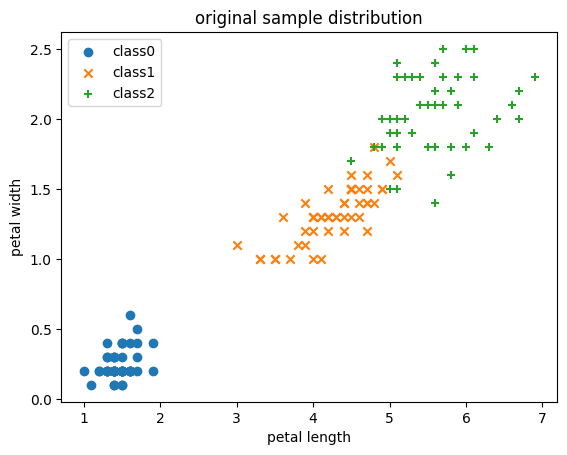

/Users/pengyuyan/PSH/Machine_learning_basics/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch:  1 Likelihood:  -1304.7273674599232
Epoch:  2 Likelihood:  -531.5270804508837
Epoch:  3 Likelihood:  -448.8249786955974
Epoch:  4 Likelihood:  -435.7815379489591
Epoch:  5 Likelihood:  -425.03037877899044
Epoch:  6 Likelihood:  -418.0827752401088
Epoch:  7 Likelihood:  -414.19130009096364
Epoch:  8 Likelihood:  -411.6118767858894
Epoch:  9 Likelihood:  -409.7529760109041
Epoch:  10 Likelihood:  -408.43688081283943
Epoch:  11 Likelihood:  -407.54235892569415
Epoch:  12 Likelihood:  -406.96239949643393
Epoch:  13 Likelihood:  -406.5992012920863
Epoch:  14 Likelihood:  -406.3742584506211
Epoch:  15 Likelihood:  -406.233384834115
Epoch:  16 Likelihood:  -406.1429430151355
Epoch:  17 Likelihood:  -406.08313388319067
Epoch:  18 Likelihood:  -406.0424324680175
Epoch:  19 Likelihood:  -406.0140254294805
Epoch:  20 Likelihood:  -405.99376938455237
Epoch:  21 Likelihood:  -405.9790633637257
Epoch:  22 Likelihood:  -405.9682242242631
Epoch:  23 Likelihood:  -405.9601326640625
Epoch:  24 Li

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch:  486 Likelihood:  -405.9327478197091
Epoch:  487 Likelihood:  -405.932747819709
Epoch:  488 Likelihood:  -405.9327478197092
Epoch:  489 Likelihood:  -405.9327478197092
Epoch:  490 Likelihood:  -405.9327478197092
Epoch:  491 Likelihood:  -405.9327478197091
Epoch:  492 Likelihood:  -405.932747819709
Epoch:  493 Likelihood:  -405.9327478197092
Epoch:  494 Likelihood:  -405.9327478197092
Epoch:  495 Likelihood:  -405.9327478197092
Epoch:  496 Likelihood:  -405.9327478197091
Epoch:  497 Likelihood:  -405.932747819709
Epoch:  498 Likelihood:  -405.9327478197092
Epoch:  499 Likelihood:  -405.9327478197092
Epoch:  500 Likelihood:  -405.9327478197092


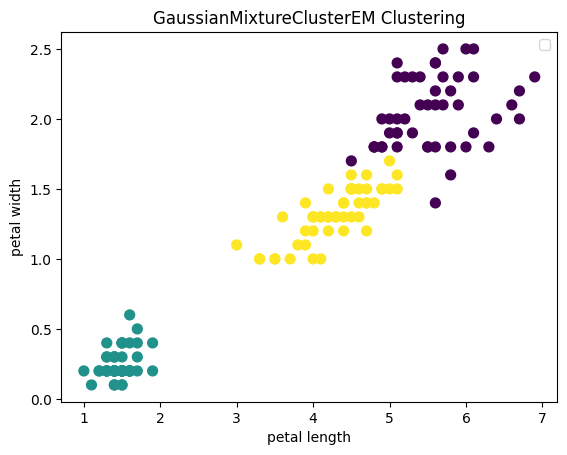

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


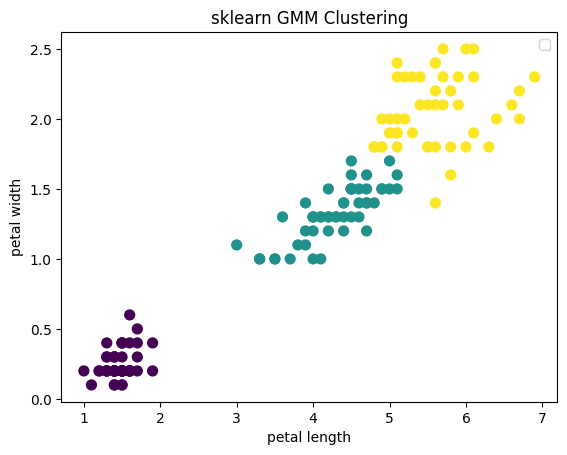

In [12]:
#读取鸢尾数据集
from sklearn import datasets
iris = datasets.load_iris()
iris_x = iris.data
iris_label = iris.target
# just using the third and fourth feature
X = iris_x[:,[2,3]]
#samples of calss0
X_0 = []
for i in range(len(iris_label)):
    if iris_label[i]==0:
        X_0.append(X[i])
X_0 = np.array(X_0)
#samples of class1
X_1 = []
for i in range(len(iris_label)):
    if iris_label[i]==1:
        X_1.append(X[i])
X_1 = np.array(X_1)
#samples of class2
X_2 = []
for i in range(len(iris_label)):
    if iris_label[i]==2:
        X_2.append(X[i])
X_2 = np.array(X_2)
#show original data
import matplotlib.pyplot as plt
plt.scatter(X_0[:,0], X_0[:,1], label="class0",marker="o")
plt.scatter(X_1[:,0], X_1[:,1], label="class1",marker="x")
plt.scatter(X_2[:,0], X_2[:,1], label="class2",marker="+")
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.title("original sample distribution")
plt.legend()
plt.show()

#使用EM类
model = GaussianMixtureClusterEM()
clusters, likelihoods, scores, sample_likelihoods, history = model.fit(X, n_clusters=3, n_epochs=500)
labels = []
for i in range(scores.shape[0]):
    max_value = scores[i,0]
    max_index = 0
    for j in range(scores.shape[1]):
        if scores[i,j] > max_value:
            max_value = scores[i,j]
            max_index = j
    labels.append(max_index)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.title("GaussianMixtureClusterEM Clustering")
plt.legend()
plt.show()

#GMM模型
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=3).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.title("sklearn GMM Clustering")
plt.legend()
plt.show()